In [1]:
from ay_torch import *

In [2]:
FUNC_KIND=3
def Func(x):
  #NOTE: Switch the function to be learned.
  global FUNC_KIND
  if FUNC_KIND==0:  return x
  if FUNC_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x,data_y

In [3]:
xmin,xmax= -5.0, 5.0
N_sample= 200
#NOTE: Adjust the sample size and noise level.
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, noise=0.5)

#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
dl_train= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)
dl_test= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
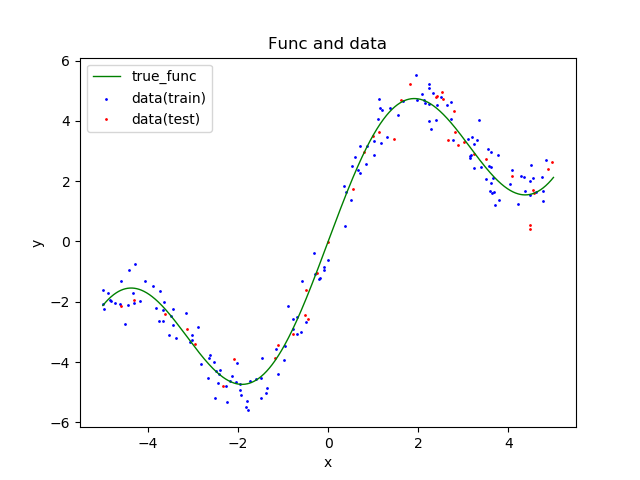

In [4]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1)
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], 1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], 1, color='red', label='data(test)')
ax_pred.set_title('Func and data')
ax_pred.set_xlabel('x')
ax_pred.set_ylabel('y')
ax_pred.legend()

In [5]:
class TRegNN1(torch.nn.Module):
  def __init__(self):
    super(TRegNN1,self).__init__()
    self.lin1= torch.nn.Linear(in_features=1, out_features=1, bias=True)
  def forward(self, x):
    x= self.lin1(x)
    return x

def DefRegNN2():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(200, 100),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(100, 1),
          )

def DefRegNN3():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN4():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN5(p=0.02):
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )

In [6]:
class TFuncList(list):
  def __init__(self, *args, **kwargs):
    super(TFuncList,self).__init__(*args, **kwargs)
  def __call__(self, *args, **kwargs):
    return [f(*args, **kwargs) for f in self]
  def __add__(self, rhs):
    if isinstance(rhs,(TFuncList,list)):
      return TFuncList(super(TFuncList,self).__add__(rhs))
    else:
      return TFuncList(super(TFuncList,self).__add__([rhs]))
  def __iadd__(self, rhs):
    if isinstance(rhs,(TFuncList,list)):
      return super(TFuncList,self).__iadd__(rhs)
    else:
      return super(TFuncList,self).__iadd__([rhs])

def _f_test(x):
  return x*x*x
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + TFuncList((lambda x: x*x*x,))
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + [lambda x: x*x*x]
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + (lambda x: x*x*x)
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + TFuncList((_f_test,))
fl= TFuncList((lambda x: x+1, lambda x: x*x)) + _f_test
# fl+= [_f_test]
fl+= _f_test
# fl= TFuncList()
fl(x=10)
# type(fl)
# f1

[11, 100, 1000, 1000]

In [7]:
class _TFLTest(object):
  def __init__(self):
    self.x= 100
  def FL(self):
    return TFuncList((lambda y,self=self: self.x*y,lambda y,self=self: self.x+y+11))
flt= _TFLTest()
fl= flt.FL()
flt.x= 150
fl(10)

[1500, 171]

In [8]:
# Function forward test:
def f1(x, y=None, *args, **kwargs):
  print(x,y)
def f2(*args, **kwargs):
  f1(*args, **kwargs)
f2(100,y=100)

100 100


In [9]:
def MergeDict(d_base, d_new, allow_new_key=True):
  if isinstance(d_new, (list,tuple)):
    for d_new_i in d_new:
      MergeDict(d_base, d_new_i)
  else:
    for k_new,v_new in d_new.iteritems() if hasattr(d_new,'iteritems') else d_new.items():
      if not allow_new_key and k_new not in d_base:
        raise Exception('MergeDict: Unexpected key:',k_new)
      if k_new in d_base and (isinstance(v_new,dict) and isinstance(d_base[k_new],dict)):
        MergeDict(d_base[k_new], v_new)
      else:
        d_base[k_new]= v_new
  return d_base  #NOTE: d_base is overwritten. Returning it is for the convenience.

def MergeDictSum(d_base, d_new, allow_new_key=True):
  if isinstance(d_new, (list,tuple)):
    for d_new_i in d_new:
      MergeDictSum(d_base, d_new_i)
  else:
    for k_new,v_new in d_new.iteritems() if hasattr(d_new,'iteritems') else d_new.items():
      if not allow_new_key and k_new not in d_base:
        raise Exception('MergeDict: Unexpected key:',k_new)
      if k_new in d_base and (isinstance(v_new,dict) and isinstance(d_base[k_new],dict)):
        MergeDictSum(d_base[k_new], v_new)
      else:
        if k_new in d_base:  d_base[k_new]+= v_new
        else:  d_base[k_new]= v_new
  return d_base  #NOTE: d_base is overwritten. Returning it is for the convenience.

d1={1:1,2:2}
d2={2:3,3:3}
d3= d2
d4={3:4,5:5}
d3= MergeDict(d1, [d3,d4])
# d3= MergeDictSum(d1, [d3,d4])
print(d1,d2,d3)

{1: 1, 2: 3, 3: 4, 5: 5} {2: 3, 3: 3} {1: 1, 2: 3, 3: 4, 5: 5}


In [10]:
d1={1:[1],2:[2]}
d2={2:[3],3:[3]}
d3= d2
d4={3:[4],5:[5]}
# d3= MergeDict(d1, [d3,d4])
d3= MergeDictSum(d1, [d3,d4])
print(d1,d2,d3)

{1: [1], 2: [2, 3], 3: [3, 4], 5: [5]} {2: [3], 3: [3, 4]} {1: [1], 2: [2, 3], 3: [3, 4], 5: [5]}


In [11]:
'''A callback interface class.'''
class TCallbacks(object):
  def Callbacks(self):
    return {fname[3:]:getattr(self,fname) for fname in dir(self) if fname.startswith('cb_')}

In [196]:
class TLogger(TCallbacks):
  def __init__(self):
    self.time_train= []
    self.time_test= []
    self.loss_train= []
    self.loss_test= []
    self.metric_train= []
    self.metric_test= []
    self.lr= []

  def cb_epoch_train_begin(self, l):
    self.t0= time.time()
  def cb_epoch_train_end(self, l):
    self.time_train.append(time.time()-self.t0)
    if l['loss']:  self.loss_train.append(l['loss'])
    if l['metric']:  self.metric_train.append(l['metric'])
  def cb_epoch_test_begin(self, l):
    self.t0= time.time()
  def cb_epoch_test_end(self, l):
    self.time_test.append(time.time()-self.t0)
    if l['loss']:  self.loss_test.append(l['loss'])
    if l['metric']:  self.metric_test.append(l['metric'])
  def cb_batch_train_end(self, l):
    self.lr.append([param_group['lr'] for param_group in l['opt'].param_groups])

  def Plot(self):
    fig, (ax_loss,ax_metric) = plt.subplots(1,2,figsize=(10,5))
    ax_loss.plot(range(len(self.loss_train)), self.loss_train, color='blue', label='loss(train)')
    ax_loss.plot(range(len(self.loss_test)), self.loss_test, color='red', label='loss(test)')
    ax_metric.plot(range(len(self.metric_train)), self.metric_train, color='blue', label='metric(train)')
    ax_metric.plot(range(len(self.metric_test)), self.metric_test, color='red', label='metric(test)')
    ax_loss.set_title('Learning curve (loss)')
    ax_loss.set_xlabel('epoch')
    ax_loss.set_ylabel('loss')
    ax_loss.set_yscale('log')
    ax_loss.legend()
    ax_metric.set_title('Learning curve (metric)')
    ax_metric.set_xlabel('epoch')
    ax_metric.set_ylabel('metric')
    ax_metric.set_yscale('log')
    ax_metric.legend()
    plt.show()

  def PlotLR(self):
    fig, (ax_lr) = plt.subplots(1,1)
    ax_lr.plot(range(len(self.lr)), self.lr, color='blue', label='lr')
    ax_lr.set_title('Learning rate')
    ax_lr.set_xlabel('iteration')
    ax_lr.set_ylabel('lr')
    ax_lr.legend()
    plt.show()

In [13]:
class TDisp(TCallbacks):
  def cb_fit_begin(self, l):
    print('loss(train)\tloss(test)\tmetric(test)\ttime')
  def cb_epoch_train_begin(self, l):
    self.t0= time.time()
  def cb_epoch_train_end(self, l):
    self.time_train= time.time()-self.t0
    self.loss_train= l['loss']
  def cb_epoch_test_begin(self, l):
    self.t0= time.time()
  def cb_epoch_test_end(self, l):
    self.time_test= time.time()-self.t0
    self.loss_test= l['loss']
    self.metric_test= l['metric']
    print(f'{self.loss_train}\t{self.loss_test}\t{self.metric_test}\t{self.time_train+self.time_test}')

In [130]:
'''
Prediction helper.
'''
def PredBatch(net, batch, tfm_batch=None, device=None, with_x=True, with_y=True):
  if next(net.parameters()).device != device:
    net.to(device)
  x,y= tfm_batch(batch)
  if isinstance(x,(tuple,list)):
    x= [xi.to(device) for xi in x]
    pred= net(*x)
  else:
    x= x.to(device)
    pred= net(x)
  if with_x:
    if with_y:  return x,y,pred
    else:       return x,pred
  else:
    if with_y:  return y,pred
    else:       return pred

'''
Helper to assign parameters.
'''
def AssignParamGroups(obj, key, params):
  for i, param_group in enumerate(obj.param_groups):
    param_group[key]= params if isinstance(params,(int,float)) else params[i]

class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

'''
net: Network model.
n_epoch: Numer of epochs.
opt: Optimizer.
f_loss: Loss.
f_metric: Metric.
dl_train: DataLoader for training.
dl_test: DataLoarder for testing.
tfm_batch: Transformation function for a batch. It should be: (x,y)=tfm_batch(batch).
  where x: input variables given to net, y: target variable.
callbacks: Dictionary of callback functions (function or TFuncList).
lr: Learning rate or list of lr.
device: cpu or cuda.
'''
def Fit(net, n_epoch, opt=None, f_loss=None, f_metric=None,
        dl_train=None, dl_test=None, tfm_batch=None,
        callbacks=None,
        lr=None,
        device=torch.device('cuda')):
  #Default arguments.
  assert(opt is not None)
  assert(f_loss is not None)
  
  device= torch.device(device)  #For type(device)==str
  if (device=='cuda' or device.type=='cuda') and not torch.cuda.is_available():
    device= torch.device('cpu')
    print('Fit:WARNING: Device is switched to cpu as cuda is not available.')

  default_callbacks= {e:TFuncList() for e in 
                      ('fit_begin', 'fit_end', 
                       'epoch_train_begin', 'epoch_train_end', 'epoch_test_begin', 'epoch_test_end',
                       'batch_train_begin', 'batch_train_end', 'batch_test_begin', 'batch_test_end',
                       'train_after_prediction', 'test_after_prediction', 'train_after_backward')}
  callbacks= MergeDictSum(default_callbacks, callbacks, allow_new_key=False) if callbacks is not None else default_callbacks

  if lr is not None:  AssignParamGroups(opt, 'lr', lr)

  try:
    t_start= time.time()
    callbacks['fit_begin'](locals())
    for i_epoch in range(n_epoch):
      try:
        if dl_train:
          callbacks['epoch_train_begin'](locals())
          sum_loss= 0.0
          sum_metric= None
          net.train()
          for i_batch, batch in enumerate(dl_train):
            try:
              callbacks['batch_train_begin'](locals())
              opt.zero_grad()
              x,y,pred= PredBatch(net, batch, tfm_batch=tfm_batch, device=device)
              callbacks['train_after_prediction'](locals())
              loss= f_loss(pred, y)
              loss.backward()
              do_opt= True
              callbacks['train_after_backward'](locals())
              if do_opt: opt.step()
              sum_loss+= loss.item()
            except CancelBatchException:
              pass
            callbacks['batch_train_end'](locals())
          loss= sum_loss/len(dl_train)
          metric= None
          callbacks['epoch_train_end'](locals())

        if dl_test:
          callbacks['epoch_test_begin'](locals())
          sum_loss= 0.0
          sum_metric= 0.0
          net.eval()
          with torch.no_grad():
            for i_batch, batch in enumerate(dl_test):
              try:
                callbacks['batch_test_begin'](locals())
                x,y,pred= PredBatch(net, batch, tfm_batch=tfm_batch, device=device)
                callbacks['test_after_prediction'](locals())
                sum_loss+= f_loss(pred, y).item()
                if f_metric:  sum_metric+= f_metric(pred, y).item()
              except CancelBatchException:
                pass
              callbacks['batch_test_end'](locals())
          loss= sum_loss/len(dl_test)
          metric= None if f_metric is None else sum_metric/len(dl_test)
          callbacks['epoch_test_end'](locals())
      except CancelEpochException:
        pass
  except CancelFitException:
    pass
  callbacks['fit_end'](locals())


In [197]:
#Setup a neural network.
#net= TRegNN1()
#net= DefRegNN2()
#net= DefRegNN3()
#net= DefRegNN4()
net= DefRegNN5()

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
#opt= torch.optim.SGD(net.parameters(), lr=0.004)
#opt= torch.optim.SGD(net.parameters(), lr=0.002, momentum=0.95)
#opt= torch.optim.Adadelta(net.parameters(), rho=0.9, eps=1e-8)
#opt= torch.optim.Adagrad(net.parameters())
#opt= torch.optim.RMSprop(net.parameters())
f_loss= torch.nn.MSELoss()
#f_loss= torch.nn.HuberLoss(reduction='mean', delta=0.1)

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [121]:
next(net.parameters()).device==torch.device('cpu')

True

loss(train)	loss(test)	metric(test)	time
3.514004647731781	2.8989275097846985	1.6946237087249756	0.17702984809875488
2.5927799940109253	2.4018764197826385	1.5069705843925476	0.11067771911621094
2.142278403043747	1.3137222826480865	1.1450347006320953	0.12380003929138184
1.561783105134964	1.0982707142829895	1.0411797910928726	0.11805987358093262
1.3236140608787537	1.1873347908258438	1.0847458988428116	0.15243172645568848


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
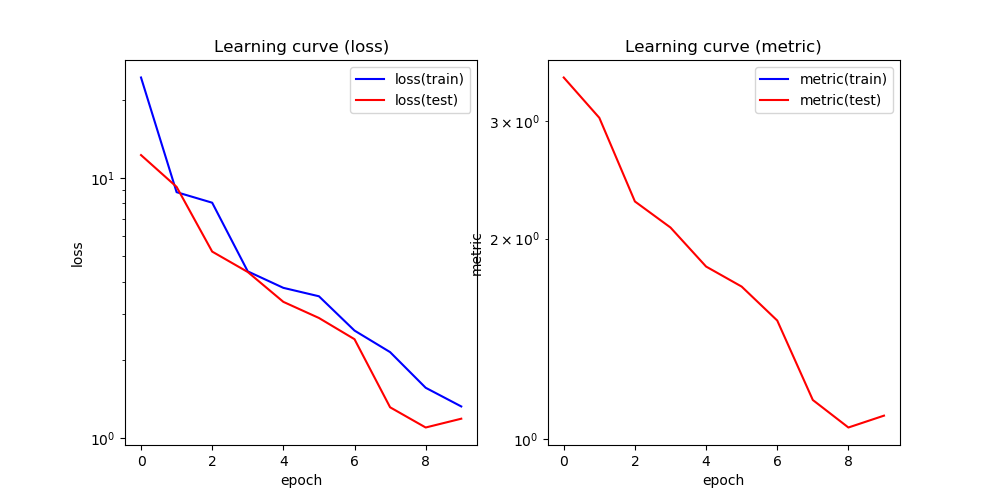

In [193]:
Fit(net, 5, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()

In [122]:
len(logger.loss_test)

0

In [123]:
[pg['lr'] for pg in opt.param_groups]
[pg.keys() for pg in opt.param_groups]
# opt
opt.state_dict()
# f_loss.state_dict()
# float('inf')

{'state': {},
 'param_groups': [{'lr': 0.01,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [131]:
class TScheduler(object):
  def __init__(self, kind, start, end):
    self.start= start
    self.end= end
    self.f= getattr(self,'f_'+kind)
  def f_lin(self, pos):  return self.start+pos*(self.end-self.start)
  def f_cos(self, pos):  return self.start+(1. + np.cos(np.pi*(1-pos)))*(self.end-self.start)/2.
  def f_exp(self, pos):  return self.start*np.power(self.end/self.start,pos)
  def __call__(self, pos):  return self.f(pos)

'''
Combination of multiple schedulers.
  via_points: List of (pos, value) pairs.
    via_points[0][0] must be 0 and via_points[-1][0] must be 1.
  kinds: Kinds of each section.
'''
class TCmbScheduler(object):
  def __init__(self, via_points, kinds):
    assert(via_points[0][0]==0. and via_points[-1][0]==1.)
    assert(len(via_points)==len(kinds)+1)
    self.via_points= via_points
    self.via_pos= np.array([pos for pos,val in via_points])
    self.schedulers= [TScheduler(k,via_points[i][1],via_points[i+1][1]) for i,k in enumerate(kinds)]
  def __call__(self, pos):
    idx= max(0,min(len(self.via_pos)-2, sum(pos>=self.via_pos)-1))
    pos_sec= (pos-self.via_points[idx][0]) / (self.via_points[idx+1][0]-self.via_points[idx][0])
    return self.schedulers[idx](pos_sec)

class TLRFinder(TCallbacks):
  def __init__(self, start_lr, end_lr, num_iter, r_div):
    self.sch= TFuncList([TScheduler('exp', s, e) for s,e in zip(start_lr,end_lr)]) \
              if isinstance(start_lr,list) else TScheduler('exp', start_lr, end_lr)
    self.i_iter= 0
    self.num_iter= num_iter
    self.r_div= r_div
    self.best_loss= float('inf')
    self.log_loss= []
    self.log_lr= []
  def cb_batch_train_begin(self, l):
    pos= self.i_iter/self.num_iter
    self.log_lr.append(self.sch(pos))
    AssignParamGroups(l['opt'], 'lr', self.log_lr[-1])
    if round(pos*100)%20==0:  print(f'FindLR progress: {pos*100}%')
    self.i_iter+= 1
  def cb_batch_train_end(self, l):
    self.log_loss.append(l['loss'].item())
    if self.log_loss[-1]<self.best_loss:  self.best_loss= self.log_loss[-1]
    if self.i_iter>self.num_iter:  raise CancelFitException()
    if self.log_loss[-1]>self.r_div*self.best_loss:  raise CancelFitException()
  def cb_fit_begin(self, l):
    self.states= {obj:copy.deepcopy(l[obj].state_dict()) for obj in ('net','opt','f_loss')}
  def cb_fit_end(self, l):
    for obj,st in self.states.items():  l[obj].load_state_dict(st)

def SuggestLRValley(log_lr, log_loss):
  n= len(log_loss)
  max_start, max_end= 0,0
  # find the longest valley
  lds= [1]*n
  for i in range(1,n):
    for j in range(0,i):
      if (log_loss[i]<log_loss[j]) and (lds[i]<lds[j]+1):
        lds[i]= lds[j]+1
      if lds[max_end]<lds[i]:
        max_end= i
        max_start= max_end-lds[max_end]
  sections= (max_end-max_start)/3
  idx= max_start+int(sections)+int(sections/2)
  return idx, (lds, max_start, max_end)

def FindLR(net, opt=None, f_loss=None, dl_train=dl_train, tfm_batch=None, device=torch.device('cuda'),
           start_lr=1e-7, end_lr=1, num_iter=100, r_div=4.0, with_suggest=True, n_filter=10, show_plot=True):
  n_epoch= num_iter//len(dl_train)+1
  lrf= TLRFinder(start_lr, end_lr, num_iter, r_div)
  Fit(net, n_epoch, opt=opt, f_loss=f_loss, f_metric=None,
      dl_train=dl_train, tfm_batch=tfm_batch,
      callbacks=lrf.Callbacks(),
      device=device)
  if with_suggest or show_plot:
    log_loss_filtered= [np.mean(lrf.log_loss[max(0,i+1-n_filter//2):i+1+n_filter//2]) for i in range(len(lrf.log_loss))]
  if with_suggest:
    lr_idx,_= SuggestLRValley(lrf.log_lr, log_loss_filtered)
  if show_plot:
    fig, ax_loss= plt.subplots(1,1)
    ax_loss.plot(lrf.log_lr, lrf.log_loss, color='blue', label='LR')
    ax_loss.plot(lrf.log_lr, log_loss_filtered, color='green', label='LR(filtered)')
    if with_suggest:  ax_loss.scatter([lrf.log_lr[lr_idx]], [log_loss_filtered[lr_idx]], color='red', label='LR(suggested)')
    ax_loss.set_xlabel('lr')
    ax_loss.set_ylabel('loss')
    ax_loss.set_xscale('log')
    ax_loss.legend()
    plt.show()
  if with_suggest:  return lrf.log_lr[lr_idx], (lrf.log_loss, lrf.log_lr)
  return lrf.log_loss, lrf.log_lr

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
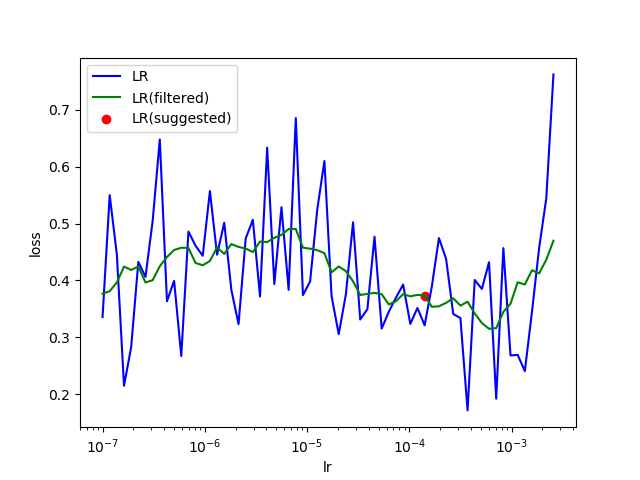

lr= 0.00014125375446227543


In [132]:
lr,_= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}')

loss(train)	loss(test)	metric(test)	time
0.41639161482453346	0.30206073820590973	0.5482069253921509	0.1501457691192627
0.4142770320177078	0.324694138020277	0.5650161504745483	0.13637852668762207
0.4320101961493492	0.3055318668484688	0.5523146241903305	0.12060117721557617
0.5441820695996284	0.2628477215766907	0.5068449079990387	0.13541173934936523
0.4087977334856987	0.2669150345027447	0.515018068253994	0.1272597312927246


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
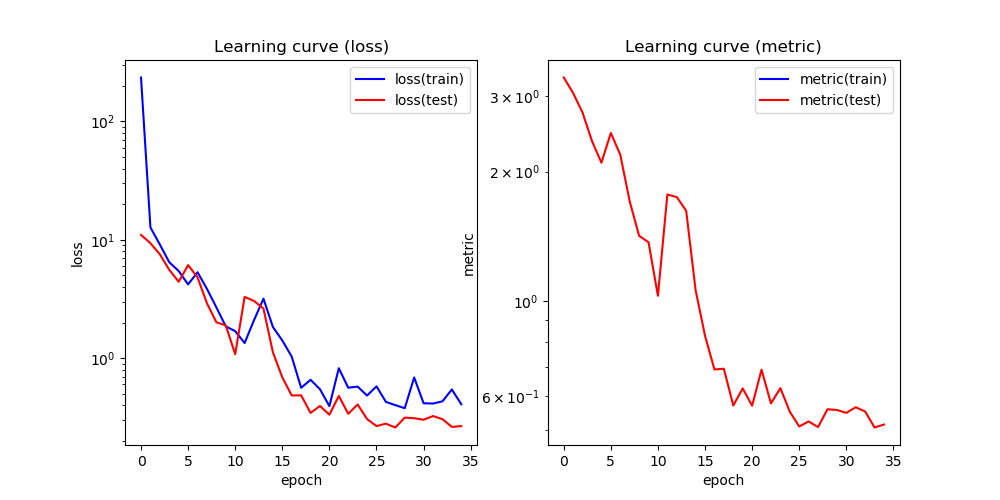

In [202]:
Fit(net, n_epoch=5, lr=lr, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
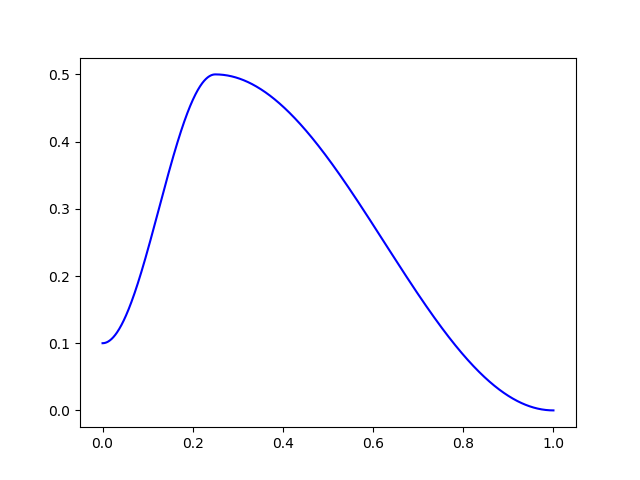

In [148]:
# via_pos= np.array([0,0.1,0.23,0.5,0.8,1.0])
# pos= np.array([0.0, 0.12, 1.2]).reshape(-1,1)
# max(0,min(len(via_pos)-2, sum(pos>=via_pos)-1))
# np.sum(pos>=via_pos,axis=1)
# cosa= lambda start,end,pos: start + (1 + np.cos(np.pi*(1-pos))) * (end-start) / 2
# sch= TScheduler('exp', 1, 0.1)
sch= TCmbScheduler(((0,0.1),(0.25,0.5),(1.0,1e-5)), ('cos','cos'))
fig, ax_loss= plt.subplots(1,1)
X= np.linspace(0,1,1000)
ax_loss.plot(X, [sch(x) for x in X], color='blue', label='LR')

In [142]:
TFuncList([TScheduler('exp', s, e) for s,e in zip([0.01,0.1],[1,10])])(0.2)

[0.0251188643150958, 0.251188643150958]

In [156]:
(lambda p: (TCmbScheduler(((0,0.1),(0.25,0.5),(1.0,1e-5)), ('cos','cos'))(p),
            TCmbScheduler(((0,np.array([0.1,0.01])),(0.25,np.array([0.5,0.05])),(1.0,np.array([1e-5,1e-6]))), ('cos','cos'))(p)))(0.5)

(0.37500250000000007, array([0.3750025 , 0.03750025]))

In [174]:
class TOneCycleScheduler(TCallbacks):
  def __init__(self, lr_max, momentums, div_init, div_final, pos_peak, num_iter):
    lr_max= lr_max if isinstance(lr_max,float) else np.array(lr_max)
    self.num_iter= num_iter
    self.sch= {'lr': TCmbScheduler(((0.,lr_max/div_init), (pos_peak,lr_max), (1.,lr_max/div_final)), ('cos','cos'))}
    if momentums is not None:
      self.sch['momentum']= TCmbScheduler(((0.,momentums[0]), (pos_peak,momentums[1]), (1.,momentums[2])), ('cos','cos'))
    self.i_iter= 0
  def cb_batch_train_begin(self, l):
    pos= self.i_iter/self.num_iter
    for key,sch in self.sch.items():
      AssignParamGroups(l['opt'], key, sch(pos))
    self.i_iter+= 1

'''
momentums: Tuple of three momentums (init, peak, final); e.g. (0.95,0.85,0.95).
'''
def FitOneCycle(net, n_epoch, opt=None, f_loss=None, f_metric=None,
                dl_train=None, dl_test=None, tfm_batch=None,
                callbacks=None,
                lr_max=None, momentums=None, div_init=25., div_final=1e5, pos_peak=0.25,
                device=torch.device('cuda')):
  assert(opt is not None)
  if lr_max is None:  lr_max= [param_group['lr'] for param_group in opt.param_groups]
  num_iter= n_epoch*len(dl_train)
  ocsch= TOneCycleScheduler(lr_max, momentums, div_init, div_final, pos_peak, num_iter)
  cbs= ocsch.Callbacks()
  callbacks= [callbacks,cbs] if isinstance(callbacks,dict) else (list(callbacks)+[cbs] if callbacks is not None else cbs)
  Fit(net, n_epoch, opt=opt, f_loss=f_loss, f_metric=f_metric,
        dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
        callbacks=callbacks, device=device)

In [172]:
# learn.lr_find()
# learn.fit_one_cycle(10, 0.006); moms=(0.95,0.85,0.95)
torch.optim.SGD(torch.nn.Linear(1,1).parameters(), lr=0.002, momentum=0.95).param_groups
# torch.optim.Adam(torch.nn.Linear(1,1).parameters(), lr=0.002).param_groups

[{'params': [Parameter containing:
   tensor([[-0.1027]], requires_grad=True),
   Parameter containing:
   tensor([-0.2844], requires_grad=True)],
  'lr': 0.002,
  'momentum': 0.95,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False}]

loss(train)	loss(test)	metric(test)	time
0.39369411766529083	0.333269938826561	0.5697290003299713	0.17887043952941895
0.8235613405704498	0.4803384318947792	0.6912711411714554	0.13460588455200195
0.5633244141936302	0.3392959237098694	0.5766975358128548	0.13316726684570312
0.5755215585231781	0.4066532030701637	0.626012347638607	0.12590360641479492
0.483486644923687	0.306268647313118	0.5517697632312775	0.1603682041168213
0.5790061950683594	0.26712294667959213	0.5096192881464958	0.12173151969909668
0.4276387393474579	0.2800833210349083	0.5236293748021126	0.11611247062683105
0.4014245569705963	0.2598433382809162	0.5079726278781891	0.1285858154296875
0.3781099356710911	0.3149647116661072	0.5589950308203697	0.11105155944824219
0.6879312843084335	0.3115090951323509	0.5567909479141235	0.12993931770324707


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
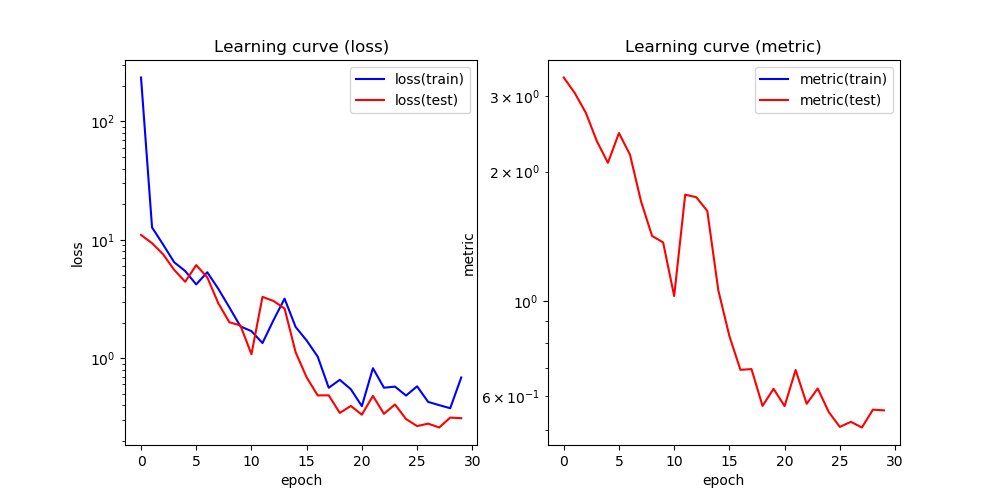

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
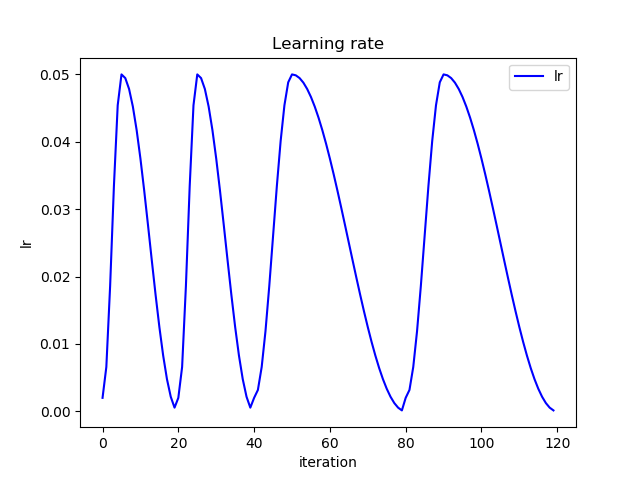

In [201]:
FitOneCycle(net, n_epoch=10, lr_max=0.05, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()